In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
from scipy.io import wavfile
import neurokit2 as nk

## Test for respiration data

### Import and visualize breathing rate data

In [ ]:
# Import and visualize breathing rate
br_hexo = pd.read_csv("data/vrt02/breathing_rate.csv")

br_hexo.rename(columns={
    br_hexo.columns[0]: "time",
    br_hexo.columns[1]: "rpm",
    br_hexo.columns[2]: "quality"
}, inplace=True)

print(br_hexo.head())
print(len(br_hexo))
print("Bad signal values: ", br_hexo["quality"].sum())

   time  rpm  quality
0   1.0   15        0
1   2.0   15        0
2   3.0   15        0
3   4.0   16        0
4   5.0   16        0
1434
Bad signal values:  0


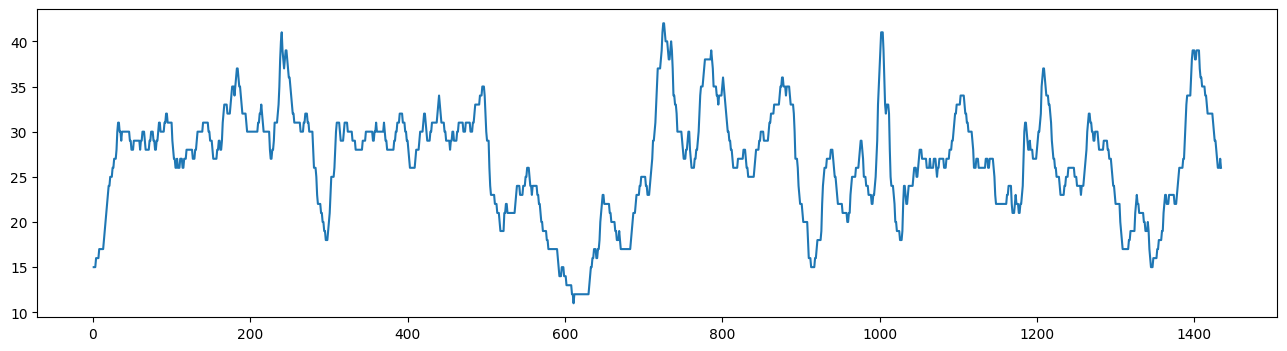

In [4]:
# Visualize breathing rate
plt.figure(figsize=(16, 4))
plt.plot(br_hexo["time"], br_hexo["rpm"])
plt.show()

### Import, visualize, then combine and visualize inspiration and expiration data again

        time  inspiration
0   0.703125        24120
1   3.312500        24108
2   6.046875        24104
3   8.531250        24100
4  11.328125        24093
        time  expiration
0   1.726562       24031
1   4.453125       24025
2   7.203125       24025
3   9.734375       24001
4  12.843750       23953


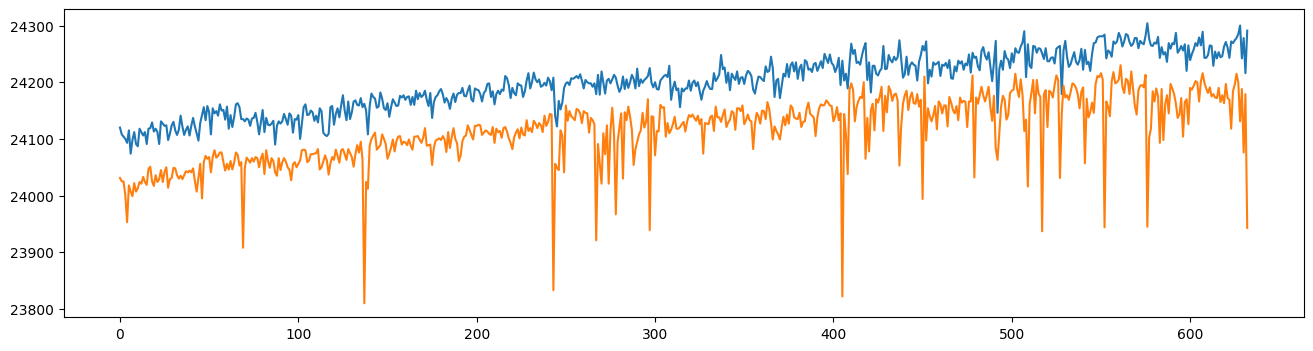

In [ ]:
# Import expiration and inspiration data
hexo_insp = pd.read_csv("data/inspiration.csv")
hexo_exp = pd.read_csv("data/expiration.csv")

hexo_insp.rename(columns={
    hexo_insp.columns[0]: "time",
    hexo_insp.columns[1]: "inspiration"
}, inplace=True)


hexo_exp.rename(columns={
    hexo_exp.columns[0]: "time",
    hexo_exp.columns[1]: "expiration"
}, inplace=True)

print(hexo_insp.head())
print(hexo_exp.head())
# Visualize inspiration and expiration
plt.figure(figsize=(16, 4))
plt.plot(hexo_insp["inspiration"])
plt.plot(hexo_exp["expiration"])
plt.show()

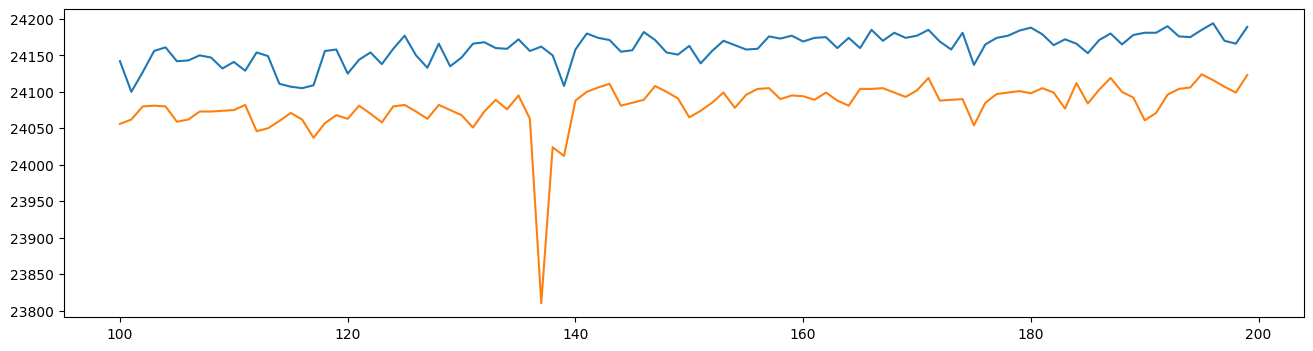

In [6]:
# Zooming in
plt.figure(figsize=(16, 4))
plt.plot(hexo_insp["inspiration"][100:200])
plt.plot(hexo_exp["expiration"][100:200])
plt.show()

In [16]:
# Combine the time columns
combined_time = np.sort(np.concatenate((hexo_insp['time'], hexo_exp['time'])))

# Initialize combined signal with NaNs
combined_signal = np.full_like(combined_time, np.nan, dtype=float)

# Assign signals based on the time points
combined_signal[np.isin(combined_time, hexo_insp['time'])] = hexo_insp['inspiration'].values
combined_signal[np.isin(combined_time, hexo_exp['time'])] = hexo_exp['expiration'].values

# Create the final dataframe
combined_df = pd.DataFrame({'time': combined_time, 'combined_signal': combined_signal})

print(combined_df)



             time  combined_signal
0        0.703125          24120.0
1        1.726562          24031.0
2        3.312500          24108.0
3        4.453125          24025.0
4        6.046875          24104.0
...           ...              ...
1261  1426.445312          24076.0
1262  1427.546875          24216.0
1263  1428.429688          24179.0
1264  1429.875000          24291.0
1265  1432.898438          23943.0

[1266 rows x 2 columns]


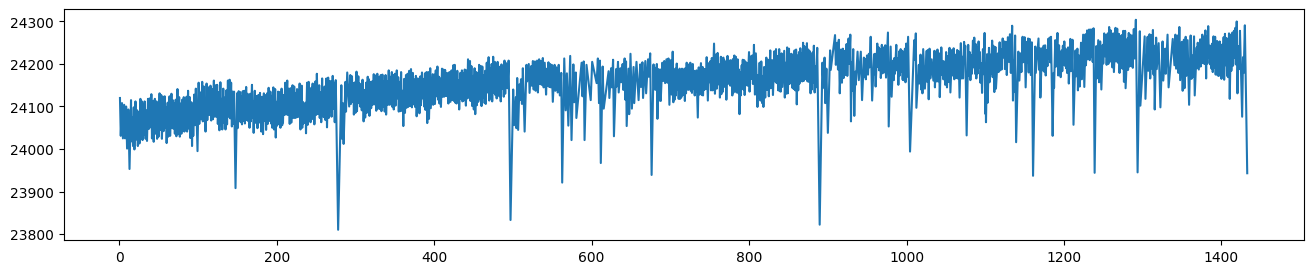

In [19]:
# Visualize the combined respiration signal
plt.figure(figsize=(16, 3))
plt.plot(combined_df["time"], combined_df["combined_signal"])
plt.show()


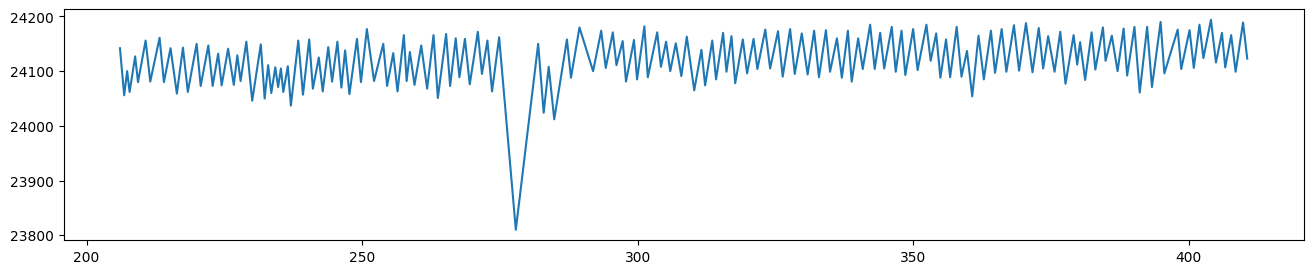

In [21]:
# Zoom in the combined respiration signal
plt.figure(figsize=(16, 3))
plt.plot(combined_df["time"][200:400], combined_df["combined_signal"][200:400])
plt.show()

In [43]:
# Simple merging of the two signals
merged_signals = pd.merge(hexo_insp, hexo_exp, how="outer", on="time")

merged_signals.head()


,time,inspiration,expiration
0,0.703125,24120.0,NaN
1,1.726562,NaN,24031.0
2,3.312500,24108.0,NaN
3,4.453125,NaN,24025.0
4,6.046875,24104.0,NaN


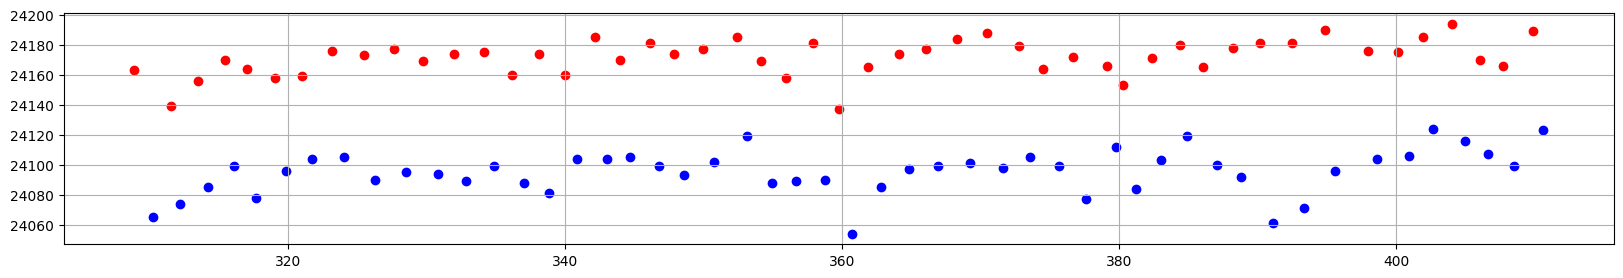

In [53]:
plt.figure(figsize=(20, 3))
plt.scatter(merged_signals["time"][300:400], merged_signals["inspiration"][300:400], color="red", label="Inspiration")
plt.scatter(merged_signals["time"][300:400], merged_signals["expiration"][300:400], color="blue", label="Expiration")
plt.grid(True)
plt.show()

### Import and visualize thoracic and abdominal signals

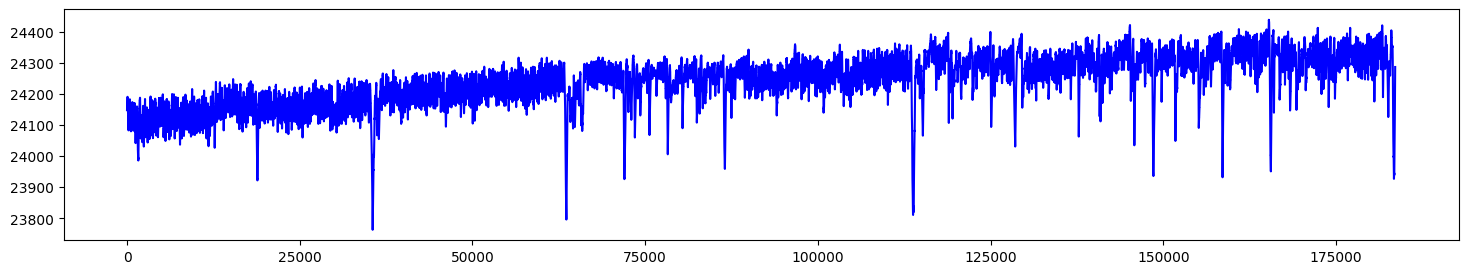

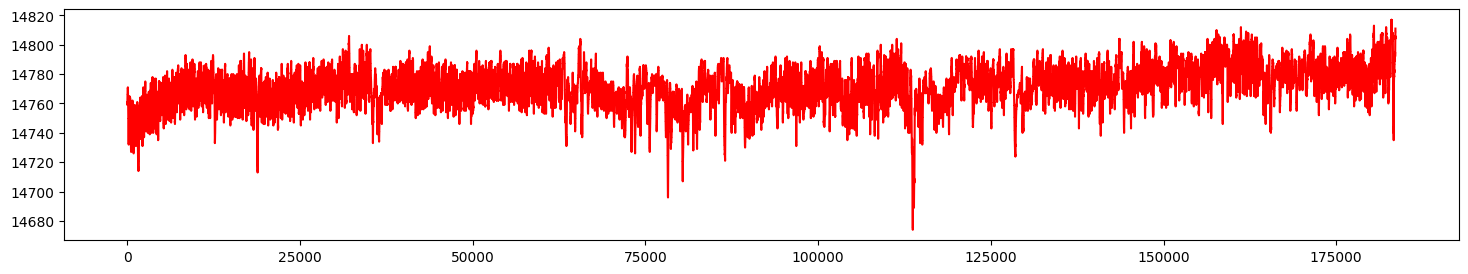

In [ ]:
# Import thoracic signal
sample_rate_thoracic, thoracic_signal = wavfile.read("data/raw/respiration_thoracic.wav")
# Import abominal signal
sample_rate_abdominal, abdominal_signal = wavfile.read("data/raw/respiration_abdominal.wav")

# Visualize the signals
plt.figure(figsize=(18, 3))
plt.plot(thoracic_signal, color="blue")
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(abdominal_signal, color="red")
plt.show()

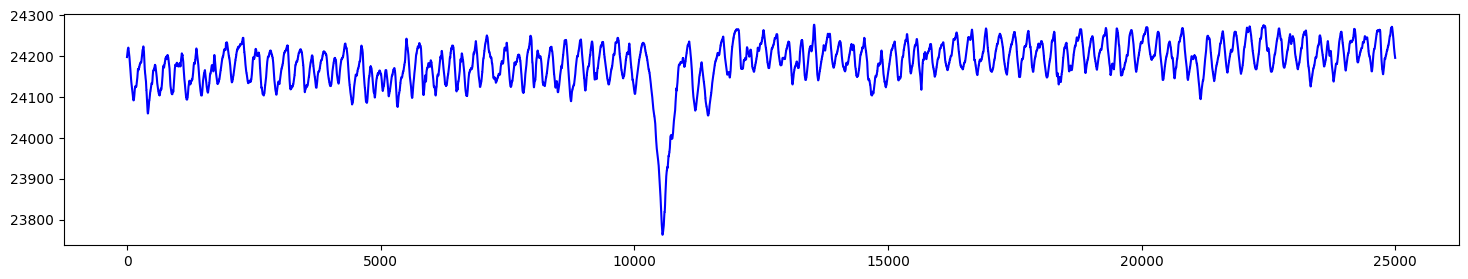

In [26]:
plt.figure(figsize=(18, 3))
plt.plot(thoracic_signal[25000:50000], color="blue")
plt.show()

### It seems thoracic sensor signal is most likely the bases of Hexoskin's respiration signal, which we reconstructed from merging inspiration and expiration data

## Calculate RRV data

In [4]:
# Process respiration signal
rsp_signals, rsp_info = nk.rsp_process(rsp_signal=thoracic_signal, sampling_rate=128, report="text")


The raw signal, sampled at 128 Hz, was preprocessed using a second order 0.05-3 Hz bandpass Butterworth filter.

The peak detection was carried out using the method described in Khoadadad et al. (2018).

The respiratory volume per time computation was carried out using the method described in Harrison et al. (2021).

|   RSP_Rate_Mean |   RSP_Rate_SD |
|----------------:|--------------:|
|         27.0807 |       7.99991 |

References
- Harrison, S. J., Bianchi, S., Heinzle, J., Stephan, K. E., Iglesias, S., & Kasper, L. (2021).
            A Hilbert-based method for processing respiratory timeseries.
            Neuroimage, 230, 117787.
- Khodadad, D., Nordebo, S., Müller, B., Waldmann, A., Yerworth, R., Becher, T., ... & Bayford, R. (2018).
            Optimized breath detection algorithm in electrical impedance tomography.
            Physiological measurement, 39(9), 094001.
- Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lespinasse, F., Pham, H.,
    Schölzel, C., & Chen, S.

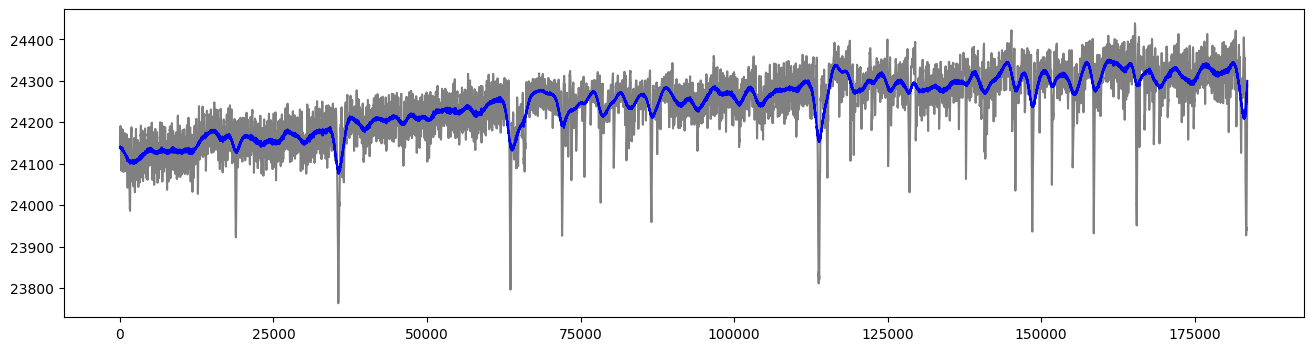

In [59]:
# Subtract clean signal from raw signal for easier visual comparison
rsp_signal_aligned = rsp_signals["RSP_Raw"] - rsp_signals["RSP_Clean"]

# Compare the raw and clean signals
plt.figure(figsize=(16, 4))
plt.plot(rsp_signals["RSP_Raw"], color="gray")
plt.plot(rsp_signal_aligned, color="blue")
plt.show()

In [64]:
# Calculate RRV
rrv_df = nk.rsp_analyze(rsp_signals, sampling_rate=128, method="auto")
rrv_df

,RSP_Rate_Mean,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,...,RAV_Mean,RAV_SD,RAV_RMSSD,RAV_CVSD,RSP_RVT,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Phase_Duration_Inspiration,RSP_Phase_Duration_Expiration,RSP_Phase_Duration_Ratio
0,27.08066,943.003388,2251.052397,856.169818,943.75138,0.380342,0.418917,2078.125,486.478125,0.234095,...,108.134192,52.255005,69.708615,0.644649,39.707736,0.441295,0.609978,1.365519,0.870122,1.569342


In [66]:
rrv_interval = nk.rsp_intervalrelated(rsp_signals, sampling_rate=128)
rrv_interval

,RSP_Rate_Mean,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,...,RAV_Mean,RAV_SD,RAV_RMSSD,RAV_CVSD,RSP_RVT,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Phase_Duration_Inspiration,RSP_Phase_Duration_Expiration,RSP_Phase_Duration_Ratio
0,27.08066,943.003388,2251.052397,856.169818,943.75138,0.380342,0.418917,2078.125,486.478125,0.234095,...,108.134192,52.255005,69.708615,0.644649,39.707736,0.441295,0.609978,1.365519,0.870122,1.569342


In [68]:
print(rrv_interval.columns)

Index(['RSP_Rate_Mean', 'RRV_RMSSD', 'RRV_MeanBB', 'RRV_SDBB', 'RRV_SDSD',
       'RRV_CVBB', 'RRV_CVSD', 'RRV_MedianBB', 'RRV_MadBB', 'RRV_MCVBB',
       'RRV_VLF', 'RRV_LF', 'RRV_HF', 'RRV_LFHF', 'RRV_LFn', 'RRV_HFn',
       'RRV_SD1', 'RRV_SD2', 'RRV_SD2SD1', 'RRV_ApEn', 'RRV_SampEn',
       'RRV_DFA_alpha1', 'RRV_MFDFA_alpha1_Width', 'RRV_MFDFA_alpha1_Peak',
       'RRV_MFDFA_alpha1_Mean', 'RRV_MFDFA_alpha1_Max',
       'RRV_MFDFA_alpha1_Delta', 'RRV_MFDFA_alpha1_Asymmetry',
       'RRV_MFDFA_alpha1_Fluctuation', 'RRV_MFDFA_alpha1_Increment',
       'RRV_DFA_alpha2', 'RRV_MFDFA_alpha2_Width', 'RRV_MFDFA_alpha2_Peak',
       'RRV_MFDFA_alpha2_Mean', 'RRV_MFDFA_alpha2_Max',
       'RRV_MFDFA_alpha2_Delta', 'RRV_MFDFA_alpha2_Asymmetry',
       'RRV_MFDFA_alpha2_Fluctuation', 'RRV_MFDFA_alpha2_Increment',
       'RAV_Mean', 'RAV_SD', 'RAV_RMSSD', 'RAV_CVSD', 'RSP_RVT',
       'RSP_Symmetry_PeakTrough', 'RSP_Symmetry_RiseDecay',
       'RSP_Phase_Duration_Inspiration', 'RSP_Phase_Durati

## Create respiration dataframe for all participants

In [2]:
# Function for RRV data creation
def create_rrv_data(filepath, session, files, metrics, method):
    """
    Function to load, process, clean, and analyze RSP signal from CSV files.

    Args:
        filepath (str): The path to the folder of the ECG files.
        session (str): The type of session: "exam", "rs", or "bl".
        files (list): A list of filenames in the folder to load.
        metrics (list): List of HRV metrics to include in the final dataframe.
        method (str): Name of the cleaning method: "khodadad2018", "biospyy"

    Returns:
        pd.DataFrame: A dataframe containing the RRV metrics for all participants.
    """
    
    # Create an empty list to store individual dataframes
    df_list = []
    
    # Load the data
    folder_path = os.path.join(filepath, session)
    
    # Loop through ECG recordings
    for file in files:
        # Extract participant ID from filename
        participant_id = file[:5]
        session_name = session
       
        # Create the full path to the file
        file_path = os.path.normpath(os.path.join(folder_path, file))
        
        # Load RSP signal
        sample_rate, rsp_signal = wavfile.read(os.path.join(folder_path, file))
        
        # Process the signal
        processed_rsp, rsp_info = nk.rsp_process(rsp_signal, sampling_rate=128, method=method)

        # Calculate RRV metrics
        rrv_data = nk.rsp_intervalrelated(processed_rsp, sampling_rate=128)
      
        # Subset for RRV metrics in focus
        rrv_data = rrv_data[metrics]

        # Add session name and participant ID
        rrv_data["session"] = session
        rrv_data["ID"] = participant_id
        
        # Add data to the list
        df_list.append(rrv_data)
        
    # Concatenate the dataframe
    rrv_combined = pd.concat(df_list, ignore_index=True)
        
    return rrv_combined

## Create exam data

In [ ]:
metrics = [
    'RSP_Rate_Mean', 'RRV_RMSSD', 'RRV_SDBB', 'RRV_SDSD',
       'RRV_VLF', 'RRV_LF', 'RRV_HF', 'RRV_LFHF', 'RRV_SD2SD1'
]

filepath = "data/raw/"

session="exam"

method="khodadad2018"

files = ["vrt02.wav", "vrt03.wav", "vrt05.wav", "vrt06.wav", "vrt07.wav",
         "vrt08.wav", "vrt10.wav", "vrt11.wav", "vrt12.wav", "vrt14.wav",
         "vrt15.wav", "vrt17.wav", "vrt18.wav", "vrt19.wav", "vrt20.wav"]

rrv_exam = create_rrv_data(filepath=filepath, session=session, files=files, metrics=metrics, method=method)
rrv_exam


,RSP_Rate_Mean,RRV_RMSSD,RRV_SDBB,RRV_SDSD,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_SD2SD1,session,ID
0,27.080660,943.003388,856.169818,943.751380,0.006049,0.003118,0.000449,6.941327,1.513947,exam,vrt02
1,25.308138,961.082442,861.894585,961.836415,0.007696,0.004401,0.000684,6.430302,1.487255,exam,vrt03
2,13.151735,2410.220012,2321.070359,2426.545654,0.007616,0.003934,0.000162,24.272157,1.630895,exam,vrt05
3,16.346107,2971.049290,2801.719606,2982.540015,0.003414,0.002308,0.000096,24.108758,1.590500,exam,vrt06
4,14.650829,2349.496835,2263.318792,2355.220049,0.008665,0.003844,0.000227,16.959128,1.641319,exam,vrt07
5,9.746158,3264.190524,2839.373071,3300.933840,0.016623,0.007188,0.000398,18.062437,1.399853,exam,vrt08
6,10.587465,4272.909123,3974.555068,4288.942148,0.012468,0.004119,0.000218,18.886595,1.560474,exam,vrt10
7,9.291820,3496.270573,2677.564404,3504.795067,0.015217,0.006820,0.000152,44.927315,1.155254,exam,vrt11
8,18.422503,2824.769064,2259.348096,2830.170768,0.013802,0.005614,0.000346,16.224869,1.244662,exam,vrt12
9,14.596204,3164.068340,2858.728801,3174.814039,0.012026,0.003926,0.000331,11.867282,1.497721,exam,vrt14


## Create baseline data

In [ ]:
metrics = [
    'RSP_Rate_Mean', 'RRV_RMSSD', 'RRV_SDBB', 'RRV_SDSD',
       'RRV_VLF', 'RRV_LF', 'RRV_HF', 'RRV_LFHF'
]

filepath = "data/raw/"

session="bl"

method="khodadad2018"
# I excluded vrt06 because the thoracic sensor disconnected (the abdominal worked)
files = ["vrt02.wav", "vrt03.wav", "vrt05.wav", "vrt07.wav",
         "vrt08.wav", "vrt10.wav", "vrt11.wav", "vrt12.wav", "vrt14.wav",
         "vrt15.wav", "vrt17.wav", "vrt18.wav", "vrt19.wav", "vrt20.wav"]

rrv_bl = create_rrv_data(filepath=filepath, session=session, files=files, metrics=metrics, method=method)
rrv_bl

,RSP_Rate_Mean,RRV_RMSSD,RRV_SDBB,RRV_SDSD,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,session,ID
0,24.286542,820.753100,738.970472,821.679134,0.011319,0.005706,0.000599,9.518484,bl,vrt02
1,21.425666,1267.585829,937.536093,1269.321049,0.012718,0.009790,0.003264,2.999504,bl,vrt03
2,21.080302,1838.670876,1567.406680,1841.614848,0.010806,0.007169,0.000614,11.681902,bl,vrt05
3,14.178900,2804.318405,2320.671153,2811.017423,0.009567,0.003869,0.000270,14.340647,bl,vrt07
4,9.905026,3219.826779,2406.296711,3242.072447,0.013205,0.005383,0.000177,30.449570,bl,vrt08
5,9.556706,4760.968616,3904.020704,4782.335273,0.015026,0.001956,0.000057,34.222505,bl,vrt10
6,12.940899,3052.224689,2237.303268,3057.555292,0.012353,0.007612,0.000215,35.411936,bl,vrt11
7,24.008964,1208.112658,1125.184395,1210.022231,0.012921,0.001703,0.000208,8.175611,bl,vrt12
8,11.296721,4459.711419,3332.299906,4470.296304,0.009723,0.006894,0.000470,14.669183,bl,vrt14
9,14.365481,3234.011433,2788.364502,3239.156318,0.013787,0.003764,0.000193,19.538094,bl,vrt15


## Create resting state data

In [ ]:
metrics = [
    'RSP_Rate_Mean', 'RRV_RMSSD', 'RRV_SDBB', 'RRV_SDSD',
       'RRV_VLF', 'RRV_LF', 'RRV_HF', 'RRV_LFHF'
]

filepath = "data/raw"

session="rs"

method="khodadad2018"

files = ["vrt02.wav", "vrt03.wav", "vrt05.wav", "vrt06.wav", "vrt07.wav",
         "vrt08.wav", "vrt10.wav", "vrt11.wav", "vrt12.wav", "vrt14.wav",
         "vrt15.wav", "vrt17.wav", "vrt18.wav", "vrt19.wav", "vrt20.wav"]

rrv_rs = create_rrv_data(filepath=filepath, session=session, files=files, metrics=metrics, method=method)
rrv_rs

,RSP_Rate_Mean,RRV_RMSSD,RRV_SDBB,RRV_SDSD,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,session,ID
0,18.542442,1147.765212,1003.635267,1154.122125,0.013753,0.010437,8.759049e-04,11.915851,rs,vrt02
1,13.464834,1029.894670,954.912386,1037.739712,0.008345,0.006113,8.105550e-05,75.423599,rs,vrt03
2,16.573031,1975.815361,1443.229843,1988.224211,0.014523,0.015114,9.886490e-04,15.287358,rs,vrt05
3,2.192444,36.084392,31.250000,36.084392,0.002230,0.000013,1.299671e-08,977.024527,rs,vrt06
4,14.237577,2067.191969,1889.197810,2079.974990,0.007449,0.002893,1.764690e-04,16.393184,rs,vrt07
5,16.814075,2658.395606,2091.830541,2675.778197,0.014469,0.012900,1.015658e-03,12.701468,rs,vrt08
6,14.334178,796.135195,622.317145,802.031038,0.010361,0.015913,1.878997e-04,84.690656,rs,vrt10
7,18.262117,1326.709886,1031.517070,1334.392919,0.015654,0.024177,1.881446e-03,12.850067,rs,vrt11
8,19.188863,582.264702,487.800236,585.331672,0.016991,0.018162,1.232184e-03,14.739865,rs,vrt12
9,15.576060,2515.271120,2480.282831,2532.743966,0.007569,0.002488,1.969954e-04,12.631006,rs,vrt14


## Combine RRV dataframes

In [9]:
combined_rrv = pd.concat([rrv_exam, rrv_bl], ignore_index=True)
combined_rrv = pd.concat([combined_rrv, rrv_rs], ignore_index=True)

## Add respiaratory bad signal ratio

- actually after manual inspection all the breathing data from vrt02 to vrt06 were the highest quality 

In [10]:
# ChatGPT code with exception handling
def create_rrv_data(filepath, session, files, metrics, method):
    """
    Function to load, process, clean, and analyze RSP signal from WAV files.
    """
    df_list = []
    folder_path = os.path.join(filepath, session)
    
    for file in files:
        participant_id = os.path.splitext(file)[0]
        session_name = session
        file_path = os.path.normpath(os.path.join(folder_path, file))
        
        try:
            sample_rate, rsp_signal = wavfile.read(file_path)
        except FileNotFoundError:
            print(f"File {file_path} not found. Skipping.")
            continue
        
        # Plot the signal to inspect it
        plt.figure(figsize=(10, 4))
        plt.plot(rsp_signal)
        plt.title(f"Raw RSP Signal for {file}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()
        
        try:
            processed_rsp, rsp_info = nk.rsp_process(rsp_signal, sampling_rate=sample_rate, method=method)
        except IndexError as e:
            print(f"Processing failed for {file} due to {e}. Skipping this file.")
            continue
        
        try:
            rrv_data = nk.rsp_intervalrelated(processed_rsp, sampling_rate=sample_rate)
            rrv_data = rrv_data[metrics]
        except KeyError as e:
            print(f"Metrics {e} not found in RRV data. Skipping {file}.")
            continue

        rrv_data["session"] = session
        rrv_data["ID"] = participant_id
        df_list.append(rrv_data)
    
    rrv_combined = pd.concat(df_list, ignore_index=True)
    return rrv_combined


In [11]:
combined_rrv

,RSP_Rate_Mean,RRV_RMSSD,RRV_SDBB,RRV_SDSD,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_SD2SD1,session,ID
0,27.080660,943.003388,856.169818,943.751380,0.006049,0.003118,4.491368e-04,6.941327,1.513947,exam,vrt02
1,25.308138,961.082442,861.894585,961.836415,0.007696,0.004401,6.844867e-04,6.430302,1.487255,exam,vrt03
2,13.151735,2410.220012,2321.070359,2426.545654,0.007616,0.003934,1.620811e-04,24.272157,1.630895,exam,vrt05
3,16.346107,2971.049290,2801.719606,2982.540015,0.003414,0.002308,9.573778e-05,24.108758,1.590500,exam,vrt06
4,14.650829,2349.496835,2263.318792,2355.220049,0.008665,0.003844,2.266652e-04,16.959128,1.641319,exam,vrt07
5,9.746158,3264.190524,2839.373071,3300.933840,0.016623,0.007188,3.979756e-04,18.062437,1.399853,exam,vrt08
6,10.587465,4272.909123,3974.555068,4288.942148,0.012468,0.004119,2.181092e-04,18.886595,1.560474,exam,vrt10
7,9.291820,3496.270573,2677.564404,3504.795067,0.015217,0.006820,1.517974e-04,44.927315,1.155254,exam,vrt11
8,18.422503,2824.769064,2259.348096,2830.170768,0.013802,0.005614,3.459838e-04,16.224869,1.244662,exam,vrt12
9,14.596204,3164.068340,2858.728801,3174.814039,0.012026,0.003926,3.308147e-04,11.867282,1.497721,exam,vrt14


In [ ]:
# Save RRV data
combined_rrv.to_csv("data/processed/combined_rrv.csv")